In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas as gpd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from time import strptime
import os 
import patsy 
from shapely.wkt import loads
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
import requests 

### Get Block Group Geometries

In [2]:
import os
os.getcwd()

'/Users/drewgobbi/Documents/GitHub/OpioidWasteWaterPilot'

In [3]:
os.chdir('/Users/drewgobbi/Documents/GitHub/OpioidWasteWaterPilot/tl_2019_39_bg')

In [4]:
oh_bg = gpd.read_file('tl_2019_39_bg.shp')

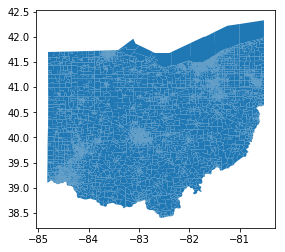

In [5]:
oh_bg.plot()

In [6]:
oh_bg.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,39,023,002403,2,390230024032,Block Group 2,G5030,S,1098505,0,+39.9571596,-083.7802214,"POLYGON ((-83.78652 39.95330, -83.78645 39.953..."
1,39,023,003002,2,390230030022,Block Group 2,G5030,S,2849335,0,+39.9023029,-083.8673265,"POLYGON ((-83.87847 39.89321, -83.87843 39.893..."
2,39,023,002200,4,390230022004,Block Group 4,G5030,S,19968071,202706,+39.8732933,-083.7491213,"POLYGON ((-83.78767 39.89338, -83.78645 39.893..."
3,39,023,003301,1,390230033011,Block Group 1,G5030,S,16997227,5247,+39.9298204,-083.6640162,"POLYGON ((-83.70346 39.92342, -83.70345 39.923..."
4,39,023,001300,2,390230013002,Block Group 2,G5030,S,2029433,0,+39.8975839,-083.7764361,"POLYGON ((-83.79095 39.90057, -83.78954 39.900..."


### Query Block Group PDB Data From Census 

In [7]:
year='2019'
dsource='pdb/blockgroup'
cols='State_name,County_name,GIDBG,Tot_Population_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,pct_NH_White_alone_CEN_2010,pct_NH_Blk_alone_ACS_13_17,pct_NH_Asian_alone_ACS_13_17,Med_HHD_Inc_BG_ACS_13_17,pct_Prs_Blw_Pov_Lev_ACS_13_17,Med_House_Value_BG_ACS_13_17,pct_College_ACS_13_17,Tract'
state='39'
county='061'
place='15000'
api_key='b76534619ffbdeef7355569c1b9cafd6a55fce2b'

In [8]:
base_url = f'https://api.census.gov/data/{year}/{dsource}'

In [9]:
data_url = f'{base_url}?get={cols}&for=block%20group:*&in=state:{state}+place={place}&in=county:{county}&in=tract:*&key={api_key}'



In [10]:
response=requests.get(data_url)

In [12]:
data=response.json()
pdb_bg=pd.DataFrame(data[1:], columns=data[0])

In [13]:
pdb_bg.head()

,State_name,County_name,GIDBG,Tot_Population_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,...,pct_NH_Asian_alone_ACS_13_17,Med_HHD_Inc_BG_ACS_13_17,pct_Prs_Blw_Pov_Lev_ACS_13_17,Med_House_Value_BG_ACS_13_17,pct_College_ACS_13_17,Tract,state,county,tract,block group
0,Ohio,Hamilton County,390610002001,1055,49.67,12.7,22.94,22.56,13.27,0.38,...,0,"$18,883",53.55,None,2.9,000200,39,061,000200,1
1,Ohio,Hamilton County,390610007001,293,60.07,29.01,49.15,7.51,14.33,4.44,...,4.78,"$63,977",31.96,None,51.92,000700,39,061,000700,1
2,Ohio,Hamilton County,390610007002,730,51.51,8.08,53.42,24.79,11.78,0.96,...,7.67,"$64,554",12.38,None,67.43,000700,39,061,000700,2
3,Ohio,Hamilton County,390610007003,510,58.82,9.8,40.39,24.12,20,9.22,...,4.12,"$86,974",10,"$284,400",70.07,000700,39,061,000700,3
4,Ohio,Hamilton County,390610009001,633,67.77,7.74,35.7,32.86,8.53,5.85,...,0,"$66,786",38.69,"$415,000",55.53,000900,39,061,000900,1


In [15]:
#tracts in Cincinnati
t = ['45.00', '46.02', '46.03', '46.05', '46.04', '47.02', '266.00', '47.01',
      '48.00', '49.00', '51.00', '53.02',
      '55.00', '56.00', '108.00', '54.00', '53.01',
      '50.00', '52.00', '58.00', '57.01', '57.02', 
      '59.00', '40.00', '38.00', '39.00',
      '41.00', '42.00', '20.00', '19.00', '268.00', '11.00', '18.00', '22.00', 
      '267.00', '33.00', '32.00', '69.00', '270.00', 
      '37.00', '36.00', '66.00', '68.00', '65.00', '64.00', 
      '63.00', '271.00', '61.00', '60.00', '110.00', '80.00', 
      '70.00', '30.00', '23.00', '17.00', '10.00', '07.00', '265.00',
      '02.00', '264.00', '09.00', '16.00', '26.00', '27.00', '29.00', 
      '72.00', '269.00', '71.00', '74.00', '75.00', '73.00', 
      '81.00', '82.02', '82.01', '111.00', '83.00', 
      '84.00', '79.00', '78.00', '85.01', '85.02', 
      '77.00', '28.00', '263.00', '96.00', '95.00', '93.00', 
      '94.00', '92.00', '272.00', '86.01', '88.00', 
      '100.02', '101.00', '102.01', '102.02', '109.00', 
      '100.03', '100.04', '100.05', '107.00', '99.01', 
      '99.02', '97.00', '103.00', '104.00', '105.00', '106.00','98.00','25.00']

In [16]:
tract = pd.DataFrame(t)

In [17]:
tract = tract.astype(float)

In [18]:
tract = tract*100

In [19]:
tract = tract.astype(int)

In [20]:
tract.rename(columns={0:'tract'},inplace=True)

In [21]:
pdb_bg.tract.sort_values()[0:5]

0    000200
1    000700
2    000700
3    000700
4    000900
Name: tract, dtype: object

In [22]:
tract.sort_values(by='tract')[0:5]

,tract
58,200
56,700
60,900
55,1000
31,1100


In [23]:
pdb_bg.tract = pdb_bg.tract.astype(int)

In [25]:
pdb_bg = pdb_bg.merge(tract, left_on='tract', right_on='tract')

In [26]:
cin = pdb_bg.merge(oh_bg, left_on='GIDBG', right_on='GEOID')

In [27]:
cin = gpd.GeoDataFrame(cin, geometry=cin.geometry)

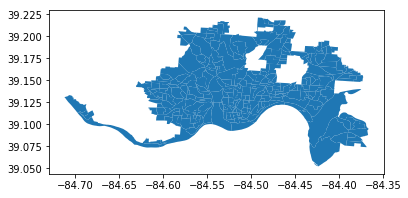

In [28]:
cin.plot()

### Merge with Tempe EMS calls

In [31]:
os.chdir('/Users/drewgobbi/Documents/GitHub/OpioidWasteWaterPilot/')


In [33]:
cinems = pd.read_csv('cincinnatiHeroinConferenceEMS_2_28_20.csv')

In [34]:
cinems.head()

,Unnamed: 0,ADDRESS_X,LATITUDE_X,LONGITUDE_X,AGENCY,CREATE_TIME_INCIDENT,DISPOSITION_TEXT,EVENT_NUMBER,INCIDENT_TYPE_ID,INCIDENT_TYPE_DESC,NEIGHBORHOOD,ARRIVAL_TIME_PRIMARY_UNIT,BEAT,CLOSED_TIME_INCIDENT,DISPATCH_TIME_PRIMARY_UNIT,CFD_INCIDENT_TYPE,CFD_INCIDENT_TYPE_GROUP,COMMUNITY_COUNCIL_NEIGHBORHOOD,Year,geometry
0,0,MCPHERSON AV,39.107164,-84.569886,CFD,2019-03-11 04:06:26,EMS: NO TRANSPORT,CFD190311000024,HEROIN-COMBINED,NaN,EAST PRICE HILL,03/11/2019 04:13:04 AM,ST17,03/11/2019 04:24:03 AM,03/11/2019 04:07:03 AM,ALS,HEROIN OVERDOSE,EAST PRICE HILL,2019,POINT (-84.569886 39.1071640000598)
1,1,RING PL,39.111616,-84.557973,CFD,2019-03-11 01:47:12,MEDT: MEDIC TRANSPORT,CFD190311000011,HEROIN-COMBINED,NaN,EAST PRICE HILL,03/11/2019 01:50:54 AM,ST17,03/11/2019 02:48:50 AM,03/11/2019 01:47:27 AM,ALS,HEROIN OVERDOSE,EAST PRICE HILL,2019,POINT (-84.557973 39.1116160000598)
2,2,WARSAW AV,39.111603,-84.571649,CFD,2019-03-11 20:20:23,MEDT: MEDIC TRANSPORT,CFD190311000173,HEROIN-COMBINED,NaN,EAST PRICE HILL,03/11/2019 08:24:38 PM,ST24,03/11/2019 09:09:27 PM,03/11/2019 08:20:40 PM,ALS,HEROIN OVERDOSE,EAST PRICE HILL,2019,POINT (-84.57164899999999 39.11160300005979)
3,3,FOREST AV / VINE ST,39.148964,-84.511357,CFD,2019-03-12 15:09:35,PT: PRIVATE TRANSPORT,CFD190312000125,HEROIN-COMBINED,NaN,CLIFTON,NaN,ST34,03/12/2019 03:14:24 PM,03/12/2019 03:09:57 PM,ALS,HEROIN OVERDOSE,CLIFTON,2019,POINT (-84.51135699999999 39.14896400005971)
4,4,E MCMILLAN ST,39.125988,-84.484162,CFD,2019-03-12 07:27:46,MED: MT RESPONSE NO TRANSPORT,CFD190312000037,HEROIN-COMBINED,NaN,WALNUT HILLS,03/12/2019 07:31:44 AM,ST23,03/12/2019 07:35:06 AM,03/12/2019 07:28:09 AM,ALS,HEROIN OVERDOSE,WALNUT HILLS,2019,POINT (-84.484162 39.1259880000598)


In [36]:
cinems['geometry'] = cinems['geometry'].apply(loads)
cinems = gpd.GeoDataFrame(cinems, geometry='geometry')

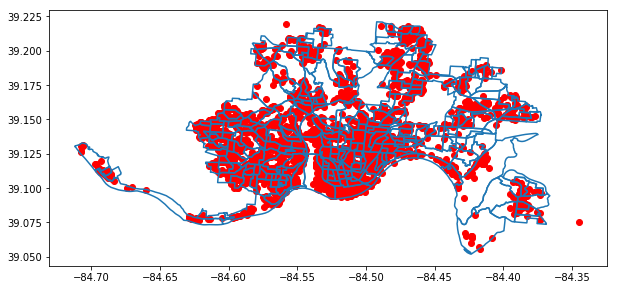

In [42]:
fig, ax = plt.subplots(figsize=(10,10))
cin.boundary.plot(ax=ax)
cinems.plot(ax=ax, color='red')

In [43]:
cin_tract = pd.DataFrame()
for i in range(len(cin)):
    df = cinems[cinems.within(cin.loc[i,'geometry'])]
    df['GIDBG'] = cin.loc[i,'GIDBG']
    cin_tract = pd.concat([cin_tract, df], axis=0)

/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [45]:
cin_tract.columns

Index(['Unnamed: 0', 'ADDRESS_X', 'LATITUDE_X', 'LONGITUDE_X', 'AGENCY',
       'CREATE_TIME_INCIDENT', 'DISPOSITION_TEXT', 'EVENT_NUMBER',
       'INCIDENT_TYPE_ID', 'INCIDENT_TYPE_DESC', 'NEIGHBORHOOD',
       'ARRIVAL_TIME_PRIMARY_UNIT', 'BEAT', 'CLOSED_TIME_INCIDENT',
       'DISPATCH_TIME_PRIMARY_UNIT', 'CFD_INCIDENT_TYPE',
       'CFD_INCIDENT_TYPE_GROUP', 'COMMUNITY_COUNCIL_NEIGHBORHOOD', 'Year',
       'geometry', 'GIDBG'],
      dtype='object')

In [46]:
cin.shape

(284, 35)

In [47]:
cin_tract.shape

(5921, 21)

In [48]:
cin_tract = cin_tract.merge(cin, on='GIDBG')

In [50]:
cin_tract.shape

(5921, 55)

In [51]:
cin_tract.columns

Index(['Unnamed: 0', 'ADDRESS_X', 'LATITUDE_X', 'LONGITUDE_X', 'AGENCY',
       'CREATE_TIME_INCIDENT', 'DISPOSITION_TEXT', 'EVENT_NUMBER',
       'INCIDENT_TYPE_ID', 'INCIDENT_TYPE_DESC', 'NEIGHBORHOOD',
       'ARRIVAL_TIME_PRIMARY_UNIT', 'BEAT', 'CLOSED_TIME_INCIDENT',
       'DISPATCH_TIME_PRIMARY_UNIT', 'CFD_INCIDENT_TYPE',
       'CFD_INCIDENT_TYPE_GROUP', 'COMMUNITY_COUNCIL_NEIGHBORHOOD', 'Year',
       'geometry_x', 'GIDBG', 'State_name', 'County_name',
       'Tot_Population_ACS_13_17', 'pct_Males_ACS_13_17',
       'pct_Pop_18_24_ACS_13_17', 'pct_Pop_25_44_ACS_13_17',
       'pct_Pop_45_64_ACS_13_17', 'pct_Pop_65plus_ACS_13_17',
       'pct_Hispanic_ACS_13_17', 'pct_NH_White_alone_CEN_2010',
       'pct_NH_Blk_alone_ACS_13_17', 'pct_NH_Asian_alone_ACS_13_17',
       'Med_HHD_Inc_BG_ACS_13_17', 'pct_Prs_Blw_Pov_Lev_ACS_13_17',
       'Med_House_Value_BG_ACS_13_17', 'pct_College_ACS_13_17', 'Tract',
       'state', 'county', 'tract', 'block group', 'STATEFP', 'COUNTYFP',
      

In [52]:
cin_tract.drop('geometry_y', inplace=True, axis=1)

In [53]:
cin_tract.rename(columns={'geometry_x':'geometry'}, inplace=True)
cin_tract = gpd.GeoDataFrame(cin_tract, geometry=cin_tract.geometry)

In [54]:
cin_tract.shape

(5921, 54)

In [55]:
cin_tract.head()

,Unnamed: 0,ADDRESS_X,LATITUDE_X,LONGITUDE_X,AGENCY,CREATE_TIME_INCIDENT,DISPOSITION_TEXT,EVENT_NUMBER,INCIDENT_TYPE_ID,INCIDENT_TYPE_DESC,...,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
0,112,EZZARD CHARLES DR,39.110180,-84.529671,CFD,2019-04-11 13:06:57,MEDT: MEDIC TRANSPORT,CFD190411000114,HEROIN-COMBINED,NaN,...,000200,1,390610002001,Block Group 1,G5030,S,303042,0,+39.1097447,-084.5296140
1,306,EZZARD CHARLES DR,39.109790,-84.529051,CFD,2019-05-25 07:27:54,MEDD: MT DISREGARDED,CFD190525000072,HEROIN-COMBINED,NaN,...,000200,1,390610002001,Block Group 1,G5030,S,303042,0,+39.1097447,-084.5296140
2,901,LINN ST,39.113610,-84.527938,CFD,2019-09-19 11:12:23,MED: MT RESPONSE NO TRANSPORT,CFD190919000103,HEROIN-COMBINED,NaN,...,000200,1,390610002001,Block Group 1,G5030,S,303042,0,+39.1097447,-084.5296140
3,1057,CLARK ST / LINN ST,39.108807,-84.528801,CFD,2019-10-28 12:50:39,IN: INVESTIGATION,CFD191028000114,HEROIN-COMBINED,NaN,...,000200,1,390610002001,Block Group 1,G5030,S,303042,0,+39.1097447,-084.5296140
4,1601,LINN ST / W LIBERTY ST,39.112910,-84.528319,CFD,2017-06-09 17:59:14,EMSF: FALSE,CFD170609000202,HEROIN-COMBINED,NaN,...,000200,1,390610002001,Block Group 1,G5030,S,303042,0,+39.1097447,-084.5296140


In [58]:
cin_tract.columns

Index(['Unnamed: 0', 'ADDRESS_X', 'LATITUDE_X', 'LONGITUDE_X', 'AGENCY',
       'CREATE_TIME_INCIDENT', 'DISPOSITION_TEXT', 'EVENT_NUMBER',
       'INCIDENT_TYPE_ID', 'INCIDENT_TYPE_DESC', 'NEIGHBORHOOD',
       'ARRIVAL_TIME_PRIMARY_UNIT', 'BEAT', 'CLOSED_TIME_INCIDENT',
       'DISPATCH_TIME_PRIMARY_UNIT', 'CFD_INCIDENT_TYPE',
       'CFD_INCIDENT_TYPE_GROUP', 'COMMUNITY_COUNCIL_NEIGHBORHOOD', 'Year',
       'geometry', 'GIDBG', 'State_name', 'County_name',
       'Tot_Population_ACS_13_17', 'pct_Males_ACS_13_17',
       'pct_Pop_18_24_ACS_13_17', 'pct_Pop_25_44_ACS_13_17',
       'pct_Pop_45_64_ACS_13_17', 'pct_Pop_65plus_ACS_13_17',
       'pct_Hispanic_ACS_13_17', 'pct_NH_White_alone_CEN_2010',
       'pct_NH_Blk_alone_ACS_13_17', 'pct_NH_Asian_alone_ACS_13_17',
       'Med_HHD_Inc_BG_ACS_13_17', 'pct_Prs_Blw_Pov_Lev_ACS_13_17',
       'Med_House_Value_BG_ACS_13_17', 'pct_College_ACS_13_17', 'Tract',
       'state', 'county', 'tract', 'block group', 'STATEFP', 'COUNTYFP',
       '

In [61]:
cin_tract['CREATE_TIME_INCIDENT'] = pd.to_datetime(cin_tract['CREATE_TIME_INCIDENT'])

In [63]:
cin_tract['CREATE_TIME_INCIDENT'].dtype

dtype('<M8[ns]')

In [65]:
cin_tract['CREATE_TIME_INCIDENT'].head()

0   2019-04-11 13:06:57
1   2019-05-25 07:27:54
2   2019-09-19 11:12:23
3   2019-10-28 12:50:39
4   2017-06-09 17:59:14
Name: CREATE_TIME_INCIDENT, dtype: datetime64[ns]

In [67]:
cin_tract['year_month'] = cin_tract['CREATE_TIME_INCIDENT'].dt.year + cin_tract['CREATE_TIME_INCIDENT'].dt.month/100

In [68]:
cin_tract['year_month'].head()

0    2019.04
1    2019.05
2    2019.09
3    2019.10
4    2017.06
Name: year_month, dtype: float64

In [70]:
cin_tract.columns

Index(['Unnamed: 0', 'ADDRESS_X', 'LATITUDE_X', 'LONGITUDE_X', 'AGENCY',
       'CREATE_TIME_INCIDENT', 'DISPOSITION_TEXT', 'EVENT_NUMBER',
       'INCIDENT_TYPE_ID', 'INCIDENT_TYPE_DESC', 'NEIGHBORHOOD',
       'ARRIVAL_TIME_PRIMARY_UNIT', 'BEAT', 'CLOSED_TIME_INCIDENT',
       'DISPATCH_TIME_PRIMARY_UNIT', 'CFD_INCIDENT_TYPE',
       'CFD_INCIDENT_TYPE_GROUP', 'COMMUNITY_COUNCIL_NEIGHBORHOOD', 'Year',
       'geometry', 'GIDBG', 'State_name', 'County_name',
       'Tot_Population_ACS_13_17', 'pct_Males_ACS_13_17',
       'pct_Pop_18_24_ACS_13_17', 'pct_Pop_25_44_ACS_13_17',
       'pct_Pop_45_64_ACS_13_17', 'pct_Pop_65plus_ACS_13_17',
       'pct_Hispanic_ACS_13_17', 'pct_NH_White_alone_CEN_2010',
       'pct_NH_Blk_alone_ACS_13_17', 'pct_NH_Asian_alone_ACS_13_17',
       'Med_HHD_Inc_BG_ACS_13_17', 'pct_Prs_Blw_Pov_Lev_ACS_13_17',
       'Med_House_Value_BG_ACS_13_17', 'pct_College_ACS_13_17', 'Tract',
       'state', 'county', 'tract', 'block group', 'STATEFP', 'COUNTYFP',
       '

In [72]:
op = cin_tract.filter(['GIDBG', 'year_month', 'EVENT_NUMBER'])

In [73]:
op.head()

,GIDBG,year_month,EVENT_NUMBER
0,390610002001,2019.04,CFD190411000114
1,390610002001,2019.05,CFD190525000072
2,390610002001,2019.09,CFD190919000103
3,390610002001,2019.10,CFD191028000114
4,390610002001,2017.06,CFD170609000202


In [74]:
#count the number of event numbers within a geocode and year_month - these are the number of ems calls 
op = op.groupby(by=[op['GIDBG'], op['year_month']]).count()

In [75]:
op.reset_index(inplace=True)

In [76]:
op.head()

,GIDBG,year_month,EVENT_NUMBER
0,390610002001,2017.02,3
1,390610002001,2017.03,1
2,390610002001,2017.04,3
3,390610002001,2017.06,1
4,390610002001,2017.09,1


In [78]:
op.rename(columns={'EVENT_NUMBER':'ems_calls'}, inplace=True)

In [79]:
var = ['geometry', 'GIDBG', 'Tot_Population_ACS_13_17','pct_Males_ACS_13_17',
       'pct_Pop_18_24_ACS_13_17','pct_Pop_25_44_ACS_13_17','pct_Pop_45_64_ACS_13_17',
       'pct_Pop_65plus_ACS_13_17','pct_Hispanic_ACS_13_17','pct_NH_White_alone_CEN_2010', 
       'pct_NH_Blk_alone_ACS_13_17','pct_NH_Asian_alone_ACS_13_17','Med_HHD_Inc_BG_ACS_13_17',
       'pct_Prs_Blw_Pov_Lev_ACS_13_17','Med_House_Value_BG_ACS_13_17','pct_College_ACS_13_17',
       'year_month']

In [81]:
cin_tract = cin_tract.filter(var)

In [82]:
cin_tract.dtypes

geometry                         geometry
GIDBG                              object
Tot_Population_ACS_13_17           object
pct_Males_ACS_13_17                object
pct_Pop_18_24_ACS_13_17            object
pct_Pop_25_44_ACS_13_17            object
pct_Pop_45_64_ACS_13_17            object
pct_Pop_65plus_ACS_13_17           object
pct_Hispanic_ACS_13_17             object
pct_NH_White_alone_CEN_2010        object
pct_NH_Blk_alone_ACS_13_17         object
pct_NH_Asian_alone_ACS_13_17       object
Med_HHD_Inc_BG_ACS_13_17           object
pct_Prs_Blw_Pov_Lev_ACS_13_17      object
Med_House_Value_BG_ACS_13_17       object
pct_College_ACS_13_17              object
year_month                        float64
dtype: object

In [83]:
cin_tract['Med_HHD_Inc_BG_ACS_13_17'] = cin_tract['Med_HHD_Inc_BG_ACS_13_17'].str.replace('$', '')
cin_tract['Med_HHD_Inc_BG_ACS_13_17'] = cin_tract['Med_HHD_Inc_BG_ACS_13_17'].str.replace(',', '')
cin_tract['Med_House_Value_BG_ACS_13_17'] = cin_tract['Med_House_Value_BG_ACS_13_17'].str.replace('$', '')
cin_tract['Med_House_Value_BG_ACS_13_17'] = cin_tract['Med_House_Value_BG_ACS_13_17'].str.replace(',', '')


In [85]:
#convert everything to floats
for i in range(1,len(cin_tract.columns)):
    cin_tract[cin_tract.columns[i]] = cin_tract[cin_tract.columns[i]].astype(float)

In [86]:
cin_tract.dtypes

geometry                         geometry
GIDBG                             float64
Tot_Population_ACS_13_17          float64
pct_Males_ACS_13_17               float64
pct_Pop_18_24_ACS_13_17           float64
pct_Pop_25_44_ACS_13_17           float64
pct_Pop_45_64_ACS_13_17           float64
pct_Pop_65plus_ACS_13_17          float64
pct_Hispanic_ACS_13_17            float64
pct_NH_White_alone_CEN_2010       float64
pct_NH_Blk_alone_ACS_13_17        float64
pct_NH_Asian_alone_ACS_13_17      float64
Med_HHD_Inc_BG_ACS_13_17          float64
pct_Prs_Blw_Pov_Lev_ACS_13_17     float64
Med_House_Value_BG_ACS_13_17      float64
pct_College_ACS_13_17             float64
year_month                        float64
dtype: object

In [87]:
cin_tract = cin_tract.groupby(by=[cin_tract['GIDBG'], cin_tract['year_month']]).mean()

In [88]:
cin_tract.head()

GIDBG  Tot_Population_ACS_13_17  \
GIDBG        year_month                                           
3.906100e+11 2017.02     3.906100e+11                    1055.0   
             2017.03     3.906100e+11                    1055.0   
             2017.04     3.906100e+11                    1055.0   
             2017.06     3.906100e+11                    1055.0   
             2017.09     3.906100e+11                    1055.0   

                         pct_Males_ACS_13_17  pct_Pop_18_24_ACS_13_17  \
GIDBG        year_month                                                 
3.906100e+11 2017.02                   49.67                     12.7   
             2017.03                   49.67                     12.7   
             2017.04                   49.67                     12.7   
             2017.06                   49.67                     12.7   
             2017.09                   49.67                     12.7   

                         pct_Pop_25_44_ACS_13_17  pct_Pop_45_64_ACS_13_17  \
GIDBG        year_month                                                     
3.906100e+11 2017.02                       22.94                    22.56   
             2017.03                       22.94                    22.56   
             2017.04                       22.94                    22.56   
             2017.06                       22.94                    22.56   
             2017.09                       22.94                    22.56   

                         pct_Pop_65plus_ACS_13_17  pct_Hispanic_ACS_13_17  \
GIDBG        year_month                                                     
3.906100e+11 2017.02                        13.27                    0.38   
             2017.03                        13.27                    0.38   
             2017.04                        13.27                    0.38   
             2017.06                        13.27                    0.38   
             2017.09                        13.27                    0.38   

                         pct_NH_White_alone_CEN_2010  \
GIDBG        year_month                                
3.906100e+11 2017.02                            1.78   
             2017.03                            1.78   
             2017.04                            1.78   
             2017.06                            1.78   
             2017.09                            1.78   

                         pct_NH_Blk_alone_ACS_13_17  \
GIDBG        year_month                               
3.906100e+11 2017.02                          94.41   
             2017.03                          94.41   
             2017.04                          94.41   
             2017.06                          94.41   
             2017.09                          94.41   

                         pct_NH_Asian_alone_ACS_13_17  \
GIDBG        year_month                                 
3.906100e+11 2017.02                              0.0   
             2017.03                              0.0   
             2017.04                              0.0   
             2017.06                              0.0   
             2017.09                              0.0   

                         Med_HHD_Inc_BG_ACS_13_17  \
GIDBG        year_month                             
3.906100e+11 2017.02                      18883.0   
             2017.03                      18883.0   
             2017.04                      18883.0   
             2017.06                      18883.0   
             2017.09                      18883.0   

                         pct_Prs_Blw_Pov_Lev_ACS_13_17  \
GIDBG        year_month                                  
3.906100e+11 2017.02                             53.55   
             2017.03                             53.55   
             2017.04                             53.55   
             2017.06                             53.55   
             2017.09                             53.55   

            

In [89]:
cin_tract.drop(columns=['GIDBG', 'year_month'], inplace=True)

In [90]:
cin_tract.reset_index(inplace=True)

In [91]:
cin_tract.head()

,GIDBG,year_month,Tot_Population_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,pct_NH_White_alone_CEN_2010,pct_NH_Blk_alone_ACS_13_17,pct_NH_Asian_alone_ACS_13_17,Med_HHD_Inc_BG_ACS_13_17,pct_Prs_Blw_Pov_Lev_ACS_13_17,Med_House_Value_BG_ACS_13_17,pct_College_ACS_13_17
0,3.906100e+11,2017.02,1055.0,49.67,12.7,22.94,22.56,13.27,0.38,1.78,94.41,0.0,18883.0,53.55,NaN,2.9
1,3.906100e+11,2017.03,1055.0,49.67,12.7,22.94,22.56,13.27,0.38,1.78,94.41,0.0,18883.0,53.55,NaN,2.9
2,3.906100e+11,2017.04,1055.0,49.67,12.7,22.94,22.56,13.27,0.38,1.78,94.41,0.0,18883.0,53.55,NaN,2.9
3,3.906100e+11,2017.06,1055.0,49.67,12.7,22.94,22.56,13.27,0.38,1.78,94.41,0.0,18883.0,53.55,NaN,2.9
4,3.906100e+11,2017.09,1055.0,49.67,12.7,22.94,22.56,13.27,0.38,1.78,94.41,0.0,18883.0,53.55,NaN,2.9


In [92]:
op.dtypes

GIDBG          object
year_month    float64
ems_calls       int64
dtype: object

In [93]:
op.GIDBG = op.GIDBG.astype(float)

In [94]:
df = cin_tract.merge(op, on=['GIDBG', 'year_month'])

In [95]:
df.shape

(3339, 17)

In [96]:
sum(df.ems_calls)

5921

In [97]:
pickle_out = open("cinems_bg_pkl_030320","wb")
pickle.dump(df, pickle_out)
pickle_out.close()

### Get Descriptive Statistics

In [168]:
bg_pkl = open('cinems_bg_pkl_030320', 'rb')

df = pickle.load(bg_pkl)

In [169]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
GIDBG,3339.0,3.906101e+11,77175.030903,3.906100e+11,3.906100e+11,3.906101e+11,3.906101e+11,3.906103e+11
year_month,3339.0,2.017994e+03,0.884079,2.017010e+03,2.017080e+03,2.018050e+03,2.019030e+03,2.020020e+03
Tot_Population_ACS_13_17,3339.0,1.061038e+03,559.266018,1.020000e+02,6.750000e+02,9.700000e+02,1.347000e+03,4.105000e+03
pct_Males_ACS_13_17,3339.0,5.035772e+01,8.655702,2.775000e+01,4.448000e+01,4.980000e+01,5.529000e+01,8.265000e+01
pct_Pop_18_24_ACS_13_17,3339.0,1.344716e+01,14.799285,0.000000e+00,6.240000e+00,9.310000e+00,1.296000e+01,9.873000e+01
pct_Pop_25_44_ACS_13_17,3339.0,2.962157e+01,10.729420,0.000000e+00,2.294000e+01,2.779000e+01,3.582000e+01,5.667000e+01
pct_Pop_45_64_ACS_13_17,3339.0,2.415297e+01,9.623963,0.000000e+00,1.849000e+01,2.383000e+01,2.916000e+01,8.039000e+01
pct_Pop_65plus_ACS_13_17,3339.0,1.138026e+01,7.587381,0.000000e+00,5.490000e+00,1.015000e+01,1.483000e+01,4.421000e+01
pct_Hispanic_ACS_13_17,3339.0,4.201285e+00,6.082849,0.000000e+00,0.000000e+00,1.570000e+00,5.030000e+00,3.235000e+01
pct_NH_White_alone_CEN_2010,3339.0,4.520033e+01,26.742498,1.540000e+00,2.144000e+01,4.643000e+01,6.637000e+01,9.530000e+01


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1eb014a8>,
      dtype=object)

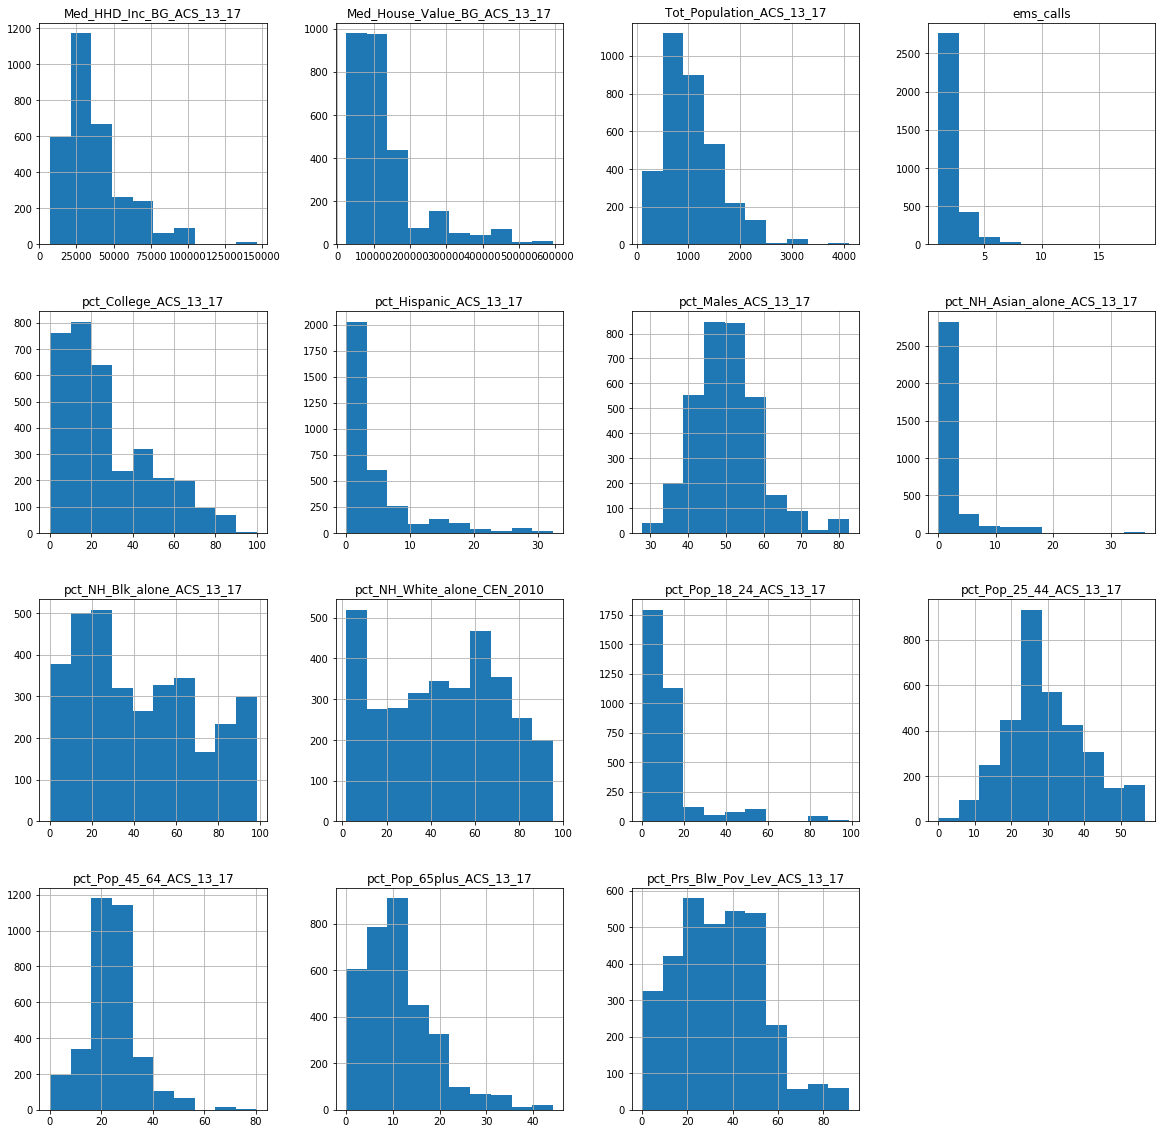

In [170]:
hist = df.drop(columns=['GIDBG', 'year_month'], axis=1)
hist.hist(figsize=(20,20))

### Rapid Test Model

In [171]:
df.dropna(inplace=True)

In [172]:
df.head()

,GIDBG,year_month,Tot_Population_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,pct_NH_White_alone_CEN_2010,pct_NH_Blk_alone_ACS_13_17,pct_NH_Asian_alone_ACS_13_17,Med_HHD_Inc_BG_ACS_13_17,pct_Prs_Blw_Pov_Lev_ACS_13_17,Med_House_Value_BG_ACS_13_17,pct_College_ACS_13_17,ems_calls
82,3.906100e+11,2017.01,510.0,58.82,9.8,40.39,24.12,20.0,9.22,56.02,10.39,4.12,86974.0,10.0,284400.0,70.07,9
83,3.906100e+11,2017.02,510.0,58.82,9.8,40.39,24.12,20.0,9.22,56.02,10.39,4.12,86974.0,10.0,284400.0,70.07,5
84,3.906100e+11,2017.03,510.0,58.82,9.8,40.39,24.12,20.0,9.22,56.02,10.39,4.12,86974.0,10.0,284400.0,70.07,10
85,3.906100e+11,2017.04,510.0,58.82,9.8,40.39,24.12,20.0,9.22,56.02,10.39,4.12,86974.0,10.0,284400.0,70.07,8
86,3.906100e+11,2017.05,510.0,58.82,9.8,40.39,24.12,20.0,9.22,56.02,10.39,4.12,86974.0,10.0,284400.0,70.07,12


In [151]:
df.shape

(2658, 17)

In [173]:
df.dtypes

GIDBG                            float64
year_month                       float64
Tot_Population_ACS_13_17         float64
pct_Males_ACS_13_17              float64
pct_Pop_18_24_ACS_13_17          float64
pct_Pop_25_44_ACS_13_17          float64
pct_Pop_45_64_ACS_13_17          float64
pct_Pop_65plus_ACS_13_17         float64
pct_Hispanic_ACS_13_17           float64
pct_NH_White_alone_CEN_2010      float64
pct_NH_Blk_alone_ACS_13_17       float64
pct_NH_Asian_alone_ACS_13_17     float64
Med_HHD_Inc_BG_ACS_13_17         float64
pct_Prs_Blw_Pov_Lev_ACS_13_17    float64
Med_House_Value_BG_ACS_13_17     float64
pct_College_ACS_13_17            float64
ems_calls                          int64
dtype: object

In [174]:
df['log_pop'] = np.log(df.Tot_Population_ACS_13_17)

In [175]:
#put into $100,000
df.Med_HHD_Inc_BG_ACS_13_17 = df.Med_HHD_Inc_BG_ACS_13_17/100000

In [176]:
df.Med_House_Value_BG_ACS_13_17 = df.Med_House_Value_BG_ACS_13_17/1000000

In [177]:
df.mean().T[0:17]

GIDBG                            3.906101e+11
year_month                       2.017984e+03
Tot_Population_ACS_13_17         1.114796e+03
pct_Males_ACS_13_17              4.952924e+01
pct_Pop_18_24_ACS_13_17          1.193701e+01
pct_Pop_25_44_ACS_13_17          3.019111e+01
pct_Pop_45_64_ACS_13_17          2.502844e+01
pct_Pop_65plus_ACS_13_17         1.126506e+01
pct_Hispanic_ACS_13_17           4.433853e+00
pct_NH_White_alone_CEN_2010      4.726721e+01
pct_NH_Blk_alone_ACS_13_17       4.169237e+01
pct_NH_Asian_alone_ACS_13_17     1.630993e+00
Med_HHD_Inc_BG_ACS_13_17         3.856195e-01
pct_Prs_Blw_Pov_Lev_ACS_13_17    3.178538e+01
Med_House_Value_BG_ACS_13_17     1.290201e-01
pct_College_ACS_13_17            2.830616e+01
ems_calls                        1.703536e+00
dtype: float64

In [178]:
#scale percentage variables 
scl = ['pct_Males_ACS_13_17',
       'pct_Pop_18_24_ACS_13_17','pct_Pop_25_44_ACS_13_17','pct_Pop_45_64_ACS_13_17',
       'pct_Pop_65plus_ACS_13_17','pct_Hispanic_ACS_13_17','pct_NH_White_alone_CEN_2010', 
       'pct_NH_Blk_alone_ACS_13_17','pct_NH_Asian_alone_ACS_13_17',
       'pct_Prs_Blw_Pov_Lev_ACS_13_17','pct_College_ACS_13_17']

for i in range(len(scl)):
    df[scl[i]] = df[scl[i]]/100

In [179]:
df.mean().T[:17]

GIDBG                            3.906101e+11
year_month                       2.017984e+03
Tot_Population_ACS_13_17         1.114796e+03
pct_Males_ACS_13_17              4.952924e-01
pct_Pop_18_24_ACS_13_17          1.193701e-01
pct_Pop_25_44_ACS_13_17          3.019111e-01
pct_Pop_45_64_ACS_13_17          2.502844e-01
pct_Pop_65plus_ACS_13_17         1.126506e-01
pct_Hispanic_ACS_13_17           4.433853e-02
pct_NH_White_alone_CEN_2010      4.726721e-01
pct_NH_Blk_alone_ACS_13_17       4.169237e-01
pct_NH_Asian_alone_ACS_13_17     1.630993e-02
Med_HHD_Inc_BG_ACS_13_17         3.856195e-01
pct_Prs_Blw_Pov_Lev_ACS_13_17    3.178538e-01
Med_House_Value_BG_ACS_13_17     1.290201e-01
pct_College_ACS_13_17            2.830616e-01
ems_calls                        1.703536e+00
dtype: float64

In [180]:
X, y = df, df.ems_calls
X.drop(columns=['ems_calls','year_month', 'Tot_Population_ACS_13_17', 'GIDBG'], inplace=True)

In [181]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [182]:
res = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              ems_calls   No. Observations:                 2126
Model:                            GLM   Df Residuals:                     2112
Model Family:                 Poisson   Df Model:                           13
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3138.3
Date:                Mon, 02 Mar 2020   Deviance:                       1323.7
Time:                        22:50:04   Pearson chi2:                 1.72e+03
No. Iterations:                     5   Covariance Type:             nonrobust
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
pct_Males_ACS_13_17               0.2934      0.248      1.185      0.236      -0.192       0

In [183]:
np.exp(res.params)

pct_Males_ACS_13_17              1.340916
pct_Pop_18_24_ACS_13_17          1.185043
pct_Pop_25_44_ACS_13_17          4.262620
pct_Pop_45_64_ACS_13_17          1.264020
pct_Pop_65plus_ACS_13_17         0.958986
pct_Hispanic_ACS_13_17           1.768170
pct_NH_White_alone_CEN_2010      0.440470
pct_NH_Blk_alone_ACS_13_17       0.404422
pct_NH_Asian_alone_ACS_13_17     1.778577
Med_HHD_Inc_BG_ACS_13_17         1.802223
pct_Prs_Blw_Pov_Lev_ACS_13_17    1.817673
Med_House_Value_BG_ACS_13_17     3.844303
pct_College_ACS_13_17            0.343987
log_pop                          1.043410
dtype: float64